<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="250" align="center">

*TRABAJO FINAL - VISIÓN POR COMPUTADORA II - JUAN I. MUNAR*

#### **SKIN CANCER: HAM10000**
#### PARTE 1 DE 2

##### **1. INTRODUCCIÓN**

En el marco del Trabajo Final de la materia Visión por Computadora II del CEIA, he elegido el tema "Detección de cáncer de piel" con el fin de trabajar en un problema concreto con sus particularidades, evalur diferentes arquitecturas y comparar los resultados obtenidos.

Obviamente este trabajo no persigue ningún fin académico relacionado a la medicina, ni reemplaza en forma alguna la opinión y el conocimiento de los dermatólogos, de hecho ni siquiera recuerdo como está compuesta una célula.

El interés general de la detección de cáncer de piel con métodos de visión por computadora radica en la dificultad de acceder a un profesional de la salud de gran parte de la población.

El dataset utilizado se obtuvo de kaggle: [Skin cancer: HAM10000](https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification/)

##### **2. ANÁLISIS EXPLORATORIO**

Análisis inicial de los datos

In [1]:
# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
# Ubicaciones y df con One Hot Encoding de clases para cada imagen
image_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
mask_dir = "/kaggle/input/ham1000-segmentation-and-classification/masks"
df = pd.read_csv("/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv")

In [3]:
# Previsualizando
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [4]:
# Obtención de labels de las columnas
df['label'] = df.drop(columns = ["image"], axis = 1).idxmax(axis=1)
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC label
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0   MEL

label
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64


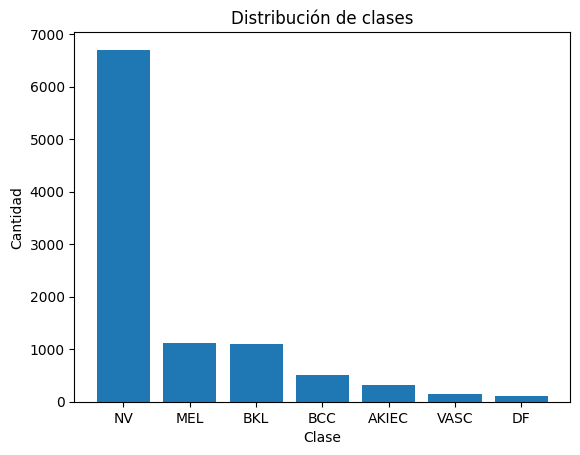

In [5]:
# Conteo de valores
print(df['label'].value_counts())

# Ploteo
plt.bar(df['label'].value_counts().index, 
        df['label'].value_counts().values)
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

- Melanocytic nevi (NV) (BENIGNO)
- Melanoma (MEL) (MALIGNO)
- Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, BKL) (BENIGNO)
- Basal cell carcinoma (BCC) (MALIGNO)
- Actinic keratoses and intraepithelial carcinoma / Bowen's disease (AKIEC) (PREMALIGNO)
- Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, VASC) (BENIGNO)
- Dermatofibroma (DF) (BENIGNO)

Se trata de un dataset claramente desbalanceado, se evaluarán diferentes alternativas de entrenamiento.

In [6]:
# Ordeno las columnas
orden_columnas = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC', 'image', 'label']
df = df[orden_columnas]
df.head()

AKIEC  BCC  BKL   DF  MEL   NV  VASC         image label
0    0.0  0.0  0.0  0.0  0.0  1.0   0.0  ISIC_0024306    NV
1    0.0  0.0  0.0  0.0  0.0  1.0   0.0  ISIC_0024307    NV
2    0.0  0.0  0.0  0.0  0.0  1.0   0.0  ISIC_0024308    NV
3    0.0  0.0  0.0  0.0  0.0  1.0   0.0  ISIC_0024309    NV
4    0.0  0.0  0.0  0.0  1.0  0.0   0.0  ISIC_0024310   MEL

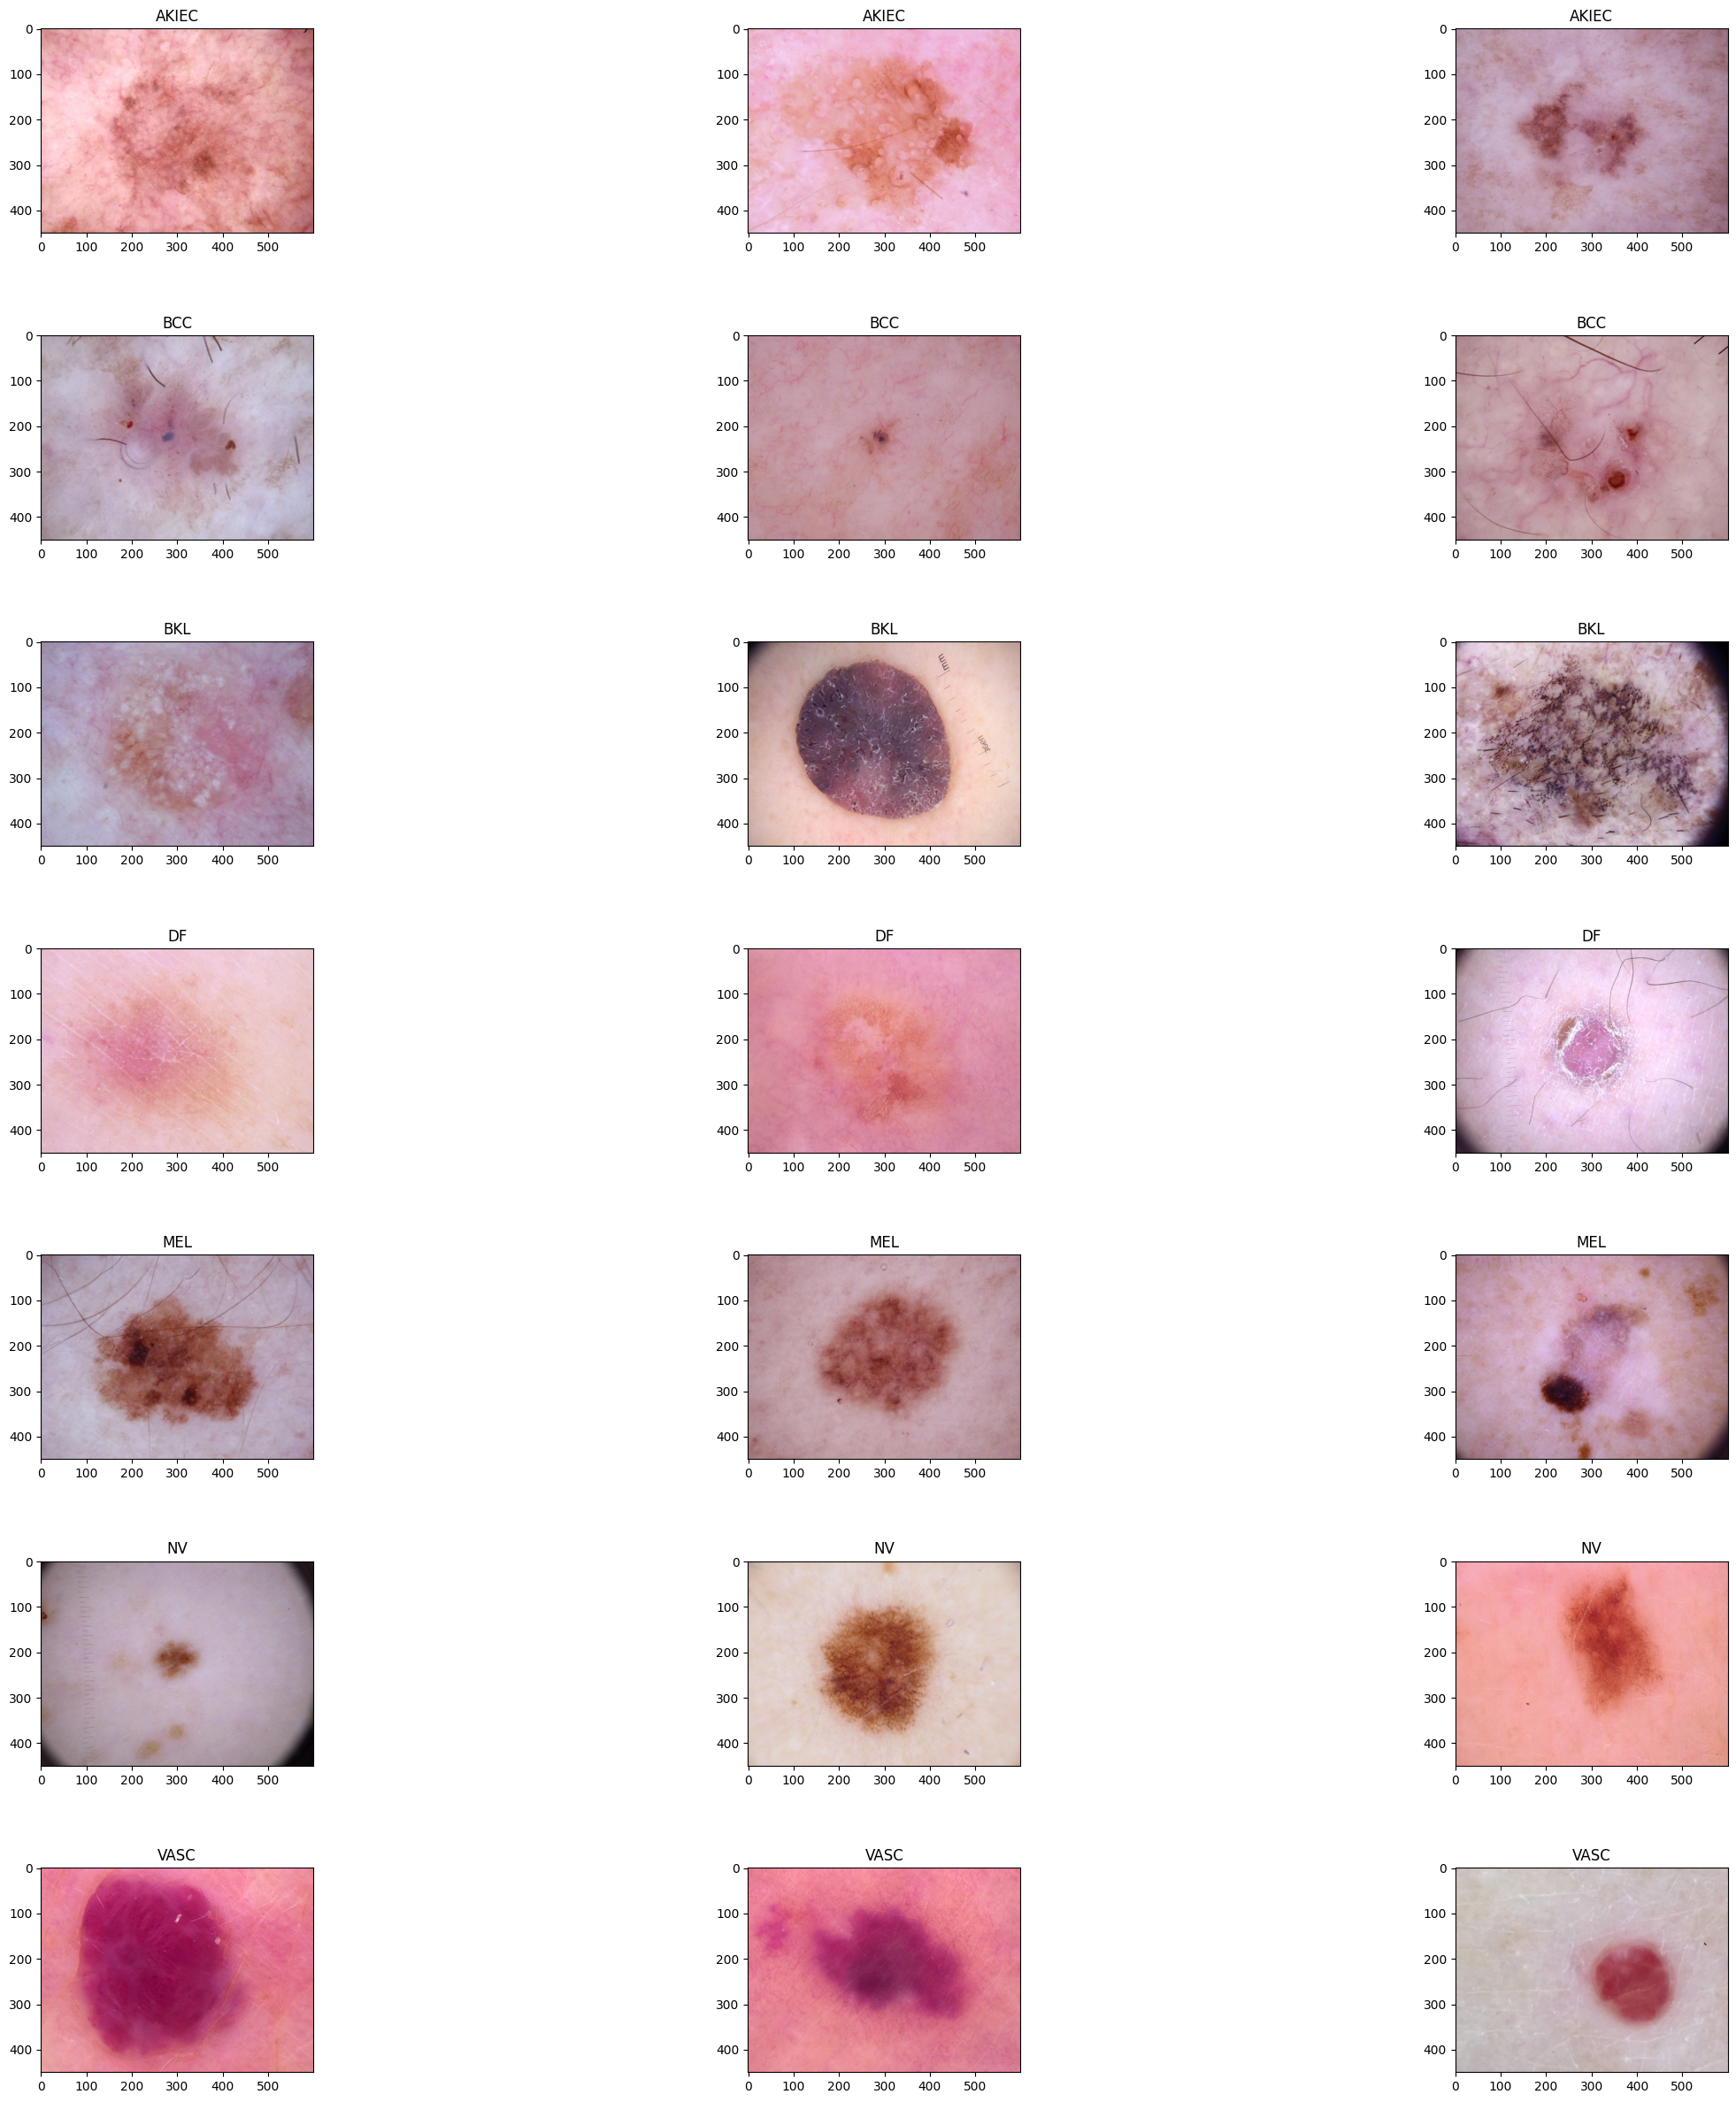

In [7]:
# Obtengo imágenes de cada clase
clases = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

fig, axs = plt.subplots(len(clases), 3, figsize=(30, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
for i in range(len(clases)):
    clase = clases[i]    
    for j in range(3):
        indice = df[df['label'] == clase].sample(n=1).index[0]
        muestra = str(df.loc[indice, 'image'])
        ruta = f'/kaggle/input/ham1000-segmentation-and-classification/images/{muestra}.jpg'
        imagen = mpimg.imread(ruta)
        axs[i,j].imshow(imagen)
        axs[i,j].title.set_text(clase)

# Borro los auxiliares
del indice, muestra, ruta, imagen

En las imágenes anteriores se pueden observar algunos de los problemas que enfrenta la detección y clasificación de estas marcas: variaciones en el color de la piel y la presencia de pelos.

In [8]:
# Creo directorios en kaggle
!mkdir -p datasets/train datasets/test
%cd /kaggle/working/datasets/train
!mkdir AKIEC BCC BKL DF MEL NV VASC
%ls

%cd /kaggle/working/datasets/test
!mkdir AKIEC BCC BKL DF MEL NV VASC
%ls

%cd /kaggle/working

/kaggle/working/datasets/train
AKIEC/  BCC/  BKL/  DF/  MEL/  NV/  VASC/
/kaggle/working/datasets/test
AKIEC/  BCC/  BKL/  DF/  MEL/  NV/  VASC/
/kaggle/working


##### **3. AJUSTE Y EVALUACIÓN DE MODELOS**

A continuación se evaluarán diferentes arquitecturas y técnicas de tratamiento de datos desbalanceados.

##### **3.1. WEIGHTED RANDOM SAMPLER**

Se probará utilizando el módulo WeightedRandomSampler para tratar con los datos desbalanceados. Se trata de incorporar pesos en el sampler para balancear el muestreo en el dataloader.

In [9]:
# Divido el dataframe en X (nombre de las imágenes) e y (clase)
from sklearn.model_selection import train_test_split
X = df['image']
y = df
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    df,
                                                    test_size=0.1,
                                                    random_state=42,
                                                    stratify=df['label'])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Como primera aproximación se utilizará el método WeightedRandomSampler para realizar un muestreo pesado en el dataloader, el código se obtuvo del siguiente [link](https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264).

In [10]:
#Obtengo los samplers
import torch
from torch.utils.data import WeightedRandomSampler

train_counts = y_train['label'].value_counts()
y_train['weights'] = y_train['label'].apply(lambda x: 1./train_counts[x])
train_samples_weight = torch.from_numpy(y_train['weights'].values)
train_samples_weight = train_samples_weight.double()

test_counts = y_test['label'].value_counts()
y_test['weights'] = y_test['label'].apply(lambda x: 1./test_counts[x])
test_samples_weight = torch.from_numpy(y_test['weights'].values)
test_samples_weight = test_samples_weight.double()

# Importante: replacement = True
train_sampler = WeightedRandomSampler(train_samples_weight, len(y_train), replacement=True)
test_sampler = WeightedRandomSampler(test_samples_weight, len(y_test), replacement=True)

In [11]:
# Importo las imágenes
import shutil
for clase in clases:
    imgs_name = X_train[y_train[clase]==1].to_list()
    for img in imgs_name:
        shutil.copy(f'/kaggle/input/ham1000-segmentation-and-classification/images/{img}.jpg', 
                    f'/kaggle/working/datasets/train/{clase}')

for clase in clases:
    imgs_name = X_test[y_test[clase]==1].to_list()
    for img in imgs_name:
        shutil.copy(f'/kaggle/input/ham1000-segmentation-and-classification/images/{img}.jpg', 
                    f'/kaggle/working/datasets/test/{clase}')

In [12]:
# Chequeo el split
%ls /kaggle/working/datasets/train/*/* | wc -l
%ls /kaggle/working/datasets/test/*/* | wc -l

9013
1002


##### **3.1.1. TRANSFER LEARNING**

Se probarán a continuación diferentes arquitecturas de clasificación clásicas sobre las cuales se hará transfer learning. La idea es aprovechar las capas que captan bordes, colores y texturas para utilizarlas en nuestro problema.

Es la intención realizar data augmentation en todos los casos para tener más datos a la vez que se tengan en cuenta diferencias de coloración, rotación, tamaño, etc. Se incluye este paso para cada punto en particular para adaptar las imágenes a los modelos preentrenados.

##### *3.1.1.1. VGG19*

Los detalles de la red se pueden leer en los siguientes docs [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556). Para realizar transfer learning se reemplaza la capa lineal final de la red.

In [13]:
# Cargo el modelo descargado previamente
import torch
from torchvision import models

# Ruta al archivo del modelo preentrenado en Kaggle
modelo_ruta = "/kaggle/input/modelos-tf/vgg19-dcbb9e9d.pth"

# Cargar el modelo desde el archivo
vgg19 = models.vgg19(weights=None)
state_dict = torch.load(modelo_ruta)
vgg19.load_state_dict(state_dict)

<All keys matched successfully>

Este método carga los pesos pero no el método transform de los pesos, durante el data augmentation se debe cuidar de realizar las transformaciones que requiere la red de base, ver *transform_test*.

Al momento de utilizar el DataLoader, se propone utilizar un sampler con pesos para tratar el problema de desbalance de datos.

In [14]:
import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Utilizo la versión v2 de torchvision.transform
transform_train = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(0.5),
    v2.ColorJitter(saturation=0.1, hue=0.1),
    v2.RandomRotation(45),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]),
])

# Transformaciones de test
transform_test = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]),
])

# Cargo datasets
train_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/train', 
    transform=transform_train
)
test_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/test', 
    transform=transform_test
)

# Cargo DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32,
    sampler=train_sampler,
    shuffle=False, # shuffle=True es incompatible con sampler
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=32,
    sampler=test_sampler,
    shuffle=False, 
    num_workers=4
)

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [15]:
# Congelo todas las capas de la red
for param in vgg19.parameters():
    param.requires_grad = False

In [16]:
# Observemos las versión corta de la arquitectura
for name, layer in vgg19.named_children():
    print(name, layer)

features Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18

In [17]:
# Modifico la última capa para adaptarse al número de clases de tu conjunto de datos
import torch.nn as nn

num_classes = len(train_dataset.classes)
last_layer_in_features = vgg19.classifier[-1].in_features
vgg19.classifier[-1] = torch.nn.Linear(
    in_features=last_layer_in_features, 
    out_features=num_classes
)

In [18]:
# Defino la función de entrenamiento
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, 
                               torch.zeros((1, 3, data["image_width"], 
                                            data["image_height"])))
        valid_writer.add_graph(model, 
                               torch.zeros((1, 3, data["image_width"], 
                                            data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_met = []
    valid_loss = []
    valid_met = []
    
    best_val_loss = float('inf')

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_metric = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            metric_ = metric(output, train_target)
            epoch_train_metric += metric_.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_metric = epoch_train_metric / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_met.append(epoch_train_metric)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_metric = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_metric += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_metric = epoch_valid_metric / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_met.append(epoch_valid_metric)
        
        if epoch_valid_loss < best_val_loss:
            best_val_loss = epoch_valid_loss
            best_params = model.state_dict()

        print("Epoch: {}/{} - Train loss {:.6f} - Train metric {:.6f} - Valid Loss {:.6f} - Valid metric {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_metric, epoch_valid_loss, epoch_valid_metric))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("metric", epoch_train_metric, epoch)
            valid_writer.add_scalar("metric", epoch_valid_metric, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_met"] = train_met
    history["valid_loss"] = valid_loss
    history["valid_met"] = valid_met
    
    torch.save(best_params, 'best_model_params.pth')
    
    return history

In [19]:
# Alto y ancho de imágenes
H = 256
W = 256

In [20]:
# Corremos el entrenamiento
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

optimizer = torch.optim.Adam(vgg19.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.F1Score(task='multiclass', num_classes=num_classes)
data = {"train": train_loader, 
        "valid": test_loader, 
        "image_width": W, 
        "image_height": H}
epochs = 50
writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}

history = train(vgg19,
                optimizer,
                loss,
                metric,
                data,
                epochs,
                writer)

Epoch: 1/50 - Train loss 1.132016 - Train metric 0.659221 - Valid Loss 1.389261 - Valid metric 0.444141
Epoch: 2/50 - Train loss 1.026206 - Train metric 0.672851 - Valid Loss 1.196887 - Valid metric 0.559961
Epoch: 3/50 - Train loss 1.008307 - Train metric 0.665870 - Valid Loss 1.232064 - Valid metric 0.525586
Epoch: 4/50 - Train loss 0.992345 - Train metric 0.672577 - Valid Loss 1.085848 - Valid metric 0.630859
Epoch: 5/50 - Train loss 0.970674 - Train metric 0.675574 - Valid Loss 1.138890 - Valid metric 0.583398
Epoch: 6/50 - Train loss 0.968268 - Train metric 0.674856 - Valid Loss 1.010431 - Valid metric 0.674219
Epoch: 7/50 - Train loss 0.962858 - Train metric 0.672028 - Valid Loss 0.922632 - Valid metric 0.713672
Epoch: 8/50 - Train loss 0.949228 - Train metric 0.676841 - Valid Loss 1.015391 - Valid metric 0.679297
Epoch: 9/50 - Train loss 0.956837 - Train metric 0.681168 - Valid Loss 1.001388 - Valid metric 0.681641
Epoch: 10/50 - Train loss 0.933033 - Train metric 0.682598 - Val

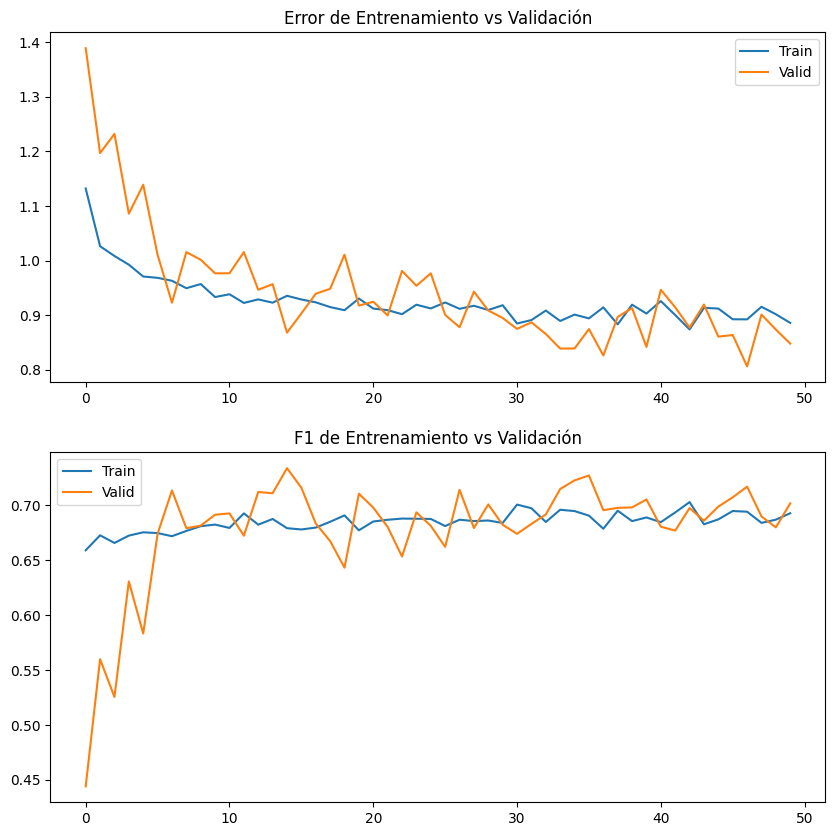

In [21]:
# Ploteo
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_met"])
axs[1].plot(history["valid_met"])
axs[1].title.set_text('F1 de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [22]:
# Cargo los mejores parámetros (min loss)
best_model_params = torch.load('best_model_params.pth')
vgg19.load_state_dict(best_model_params)

<All keys matched successfully>

In [23]:
# Evaluación del accuracy y Confusion Matrix
from torchmetrics.classification import MulticlassConfusionMatrix

all_labels = []
all_preds = []

# Todo debe correr en el mismo sitio
device = 'cuda'

# Aseguro el modelo en evaluation
vgg19.to(device)
vgg19.eval()  

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg19(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

confmat = MulticlassConfusionMatrix(num_classes=num_classes)
confmat(torch.tensor(all_preds), 
        torch.tensor(all_labels))


tensor([[  2,   4,  15,   0,   6,   8,   0],
        [  1,   0,   7,   0,   5,  51,   0],
        [  1,   0,  32,   0,  20,  39,   0],
        [  0,   0,  14,   0,   0,   2,   0],
        [  1,   2,   4,   0,  24,  39,   0],
        [  0,   0,  12,   0,  45, 647,   1],
        [  0,   0,   0,   0,   0,  15,   5]])

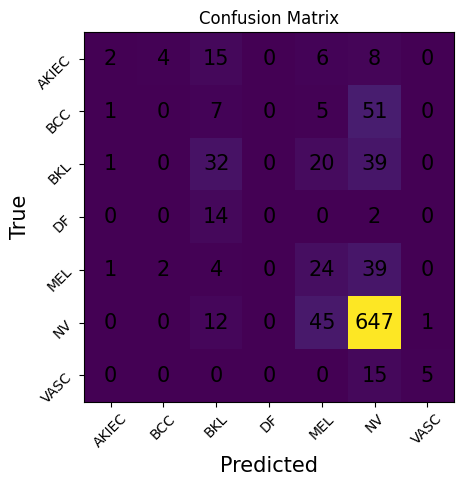

In [24]:
# Ploteo la matriz de confusion
ax_ = clases
fig_, ax_ = confmat.plot()

plt.xlabel("Predicted")
plt.ylabel("True")

ax_.set_xticklabels(clases)
plt.xticks(rotation=45)
ax_.set_yticklabels(clases)
plt.yticks(rotation=45)

plt.title("Confusion Matrix")
plt.show()

In [25]:
# Evalúo el Accuracy completo

# Aseguro el modelo en evaluation
vgg19.eval()  

correctas = 0
total = 0
device = 'cuda'

with torch.no_grad():
    for imagenes, etiquetas in test_loader:
        imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
        salidas = vgg19(imagenes)
        _, predicciones = torch.max(salidas.data, 1)
        total += etiquetas.size(0)
        correctas += (predicciones == etiquetas).sum().item()

# Calcular el accuracy
accuracy = correctas / total
print(f'Accuracy en el conjunto de pruebas: {accuracy * 100:.2f}%')

Accuracy en el conjunto de pruebas: 70.26%


In [26]:
# Evalúo el accuracy por clase
vgg19.eval()  # Asegurarte de que el modelo esté en modo de evaluación
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg19.to(device)

correct_predictions_per_class = {i: 0 for i in range(num_classes)}
total_samples_per_class = {i: 0 for i in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg19(inputs)
        _, predicted_classes = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            prediction = predicted_classes[i].item()
            total_samples_per_class[label] += 1
            correct_predictions_per_class[label] += int(label == prediction)

class_accuracies = {}
for class_label, correct_predictions in correct_predictions_per_class.items():
    total_samples = total_samples_per_class[class_label]
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    class_accuracies[class_label] = accuracy

for class_label, accuracy in class_accuracies.items():
    print(f'Accuracy for Class {clases[class_label]}: {accuracy:.2%}')

Accuracy for Class AKIEC: 0.00%
Accuracy for Class BCC: 1.96%
Accuracy for Class BKL: 36.89%
Accuracy for Class DF: 0.00%
Accuracy for Class MEL: 31.25%
Accuracy for Class NV: 89.91%
Accuracy for Class VASC: 12.50%


In [27]:
# Salvo el modelo y el estado del optimizador
ruta_modelo_completo = '/kaggle/working/vgg19'
torch.save({
    'modelo_estado_dict': vgg19.state_dict(),
    'optimizador_estado_dict': optimizer.state_dict(),
}, ruta_modelo_completo)

El modelo no tiene una buena performance

##### *3.1.1.2. ResNet50*

Probemos ajustar la red ResNet50. Los detalles de la red se pueden encontrar en [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [28]:
# Importo ResNet50
from torchvision.models import resnet50

# Ruta al archivo del modelo preentrenado en Kaggle
modelo_ruta = "/kaggle/input/modelos-tf/resnet50-11ad3fa6.pth"

# Cargar el modelo desde el archivo
resnet50_model = models.resnet50(weights=None)
state_dict = torch.load(modelo_ruta)
resnet50_model.load_state_dict(state_dict)

<All keys matched successfully>

In [29]:
import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Utilizo la versión v2 de torchvision.transform
transform_train = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(0.5),
    v2.ColorJitter(saturation=0.1, hue=0.1),
    v2.RandomRotation(45),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]),
])

# Transformaciones de test
transform_test = v2.Compose([
    v2.Resize(232),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]),
])

# Cargo datasets
train_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/train', 
    transform=transform_train
)
test_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/test', 
    transform=transform_test
)

# Cargo DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=False,
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    sampler=test_sampler,
    shuffle=False, 
    num_workers=4
)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [30]:
# Congelo todas las capas de la red
for param in resnet50_model.parameters():
    param.requires_grad = False

In [ ]:
# Observemos las versión corta de la arquitectura
for name, layer in resnet50_model.named_children():
    print(name, layer)

In [31]:
# Modifico la última capa para adaptarse al número de clases de tu conjunto de datos
import torch.nn as nn

num_classes = len(train_dataset.classes)
last_layer_in_features = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(
    in_features=last_layer_in_features, 
    out_features=num_classes
)

In [32]:
# Alto y ancho de imágenes
H = 232
W = 232

In [33]:
# Corremos el entrenamiento
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.F1Score(task='multiclass', num_classes=num_classes)
data = {"train": train_loader, 
        "valid": test_loader, 
        "image_width": W, 
        "image_height": H}
epochs = 50
writer = {"train": SummaryWriter(log_dir="transfer_learning_RN50/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_RN50/valid")}

history = train(resnet50_model,
                optimizer,
                loss,
                metric,
                data,
                epochs,
                writer)

Epoch: 1/50 - Train loss 1.348294 - Train metric 0.644671 - Valid Loss 1.117527 - Valid metric 0.682245
Epoch: 2/50 - Train loss 1.080659 - Train metric 0.670731 - Valid Loss 1.056392 - Valid metric 0.679920
Epoch: 3/50 - Train loss 1.026364 - Train metric 0.668091 - Valid Loss 0.997709 - Valid metric 0.673828
Epoch: 4/50 - Train loss 0.976982 - Train metric 0.675718 - Valid Loss 0.947835 - Valid metric 0.700428
Epoch: 5/50 - Train loss 0.946604 - Train metric 0.677274 - Valid Loss 0.948742 - Valid metric 0.697452
Epoch: 6/50 - Train loss 0.927494 - Train metric 0.679195 - Valid Loss 0.877945 - Valid metric 0.731120
Epoch: 7/50 - Train loss 0.895098 - Train metric 0.692719 - Valid Loss 0.873407 - Valid metric 0.725911
Epoch: 8/50 - Train loss 0.869178 - Train metric 0.695577 - Valid Loss 0.833377 - Valid metric 0.723354
Epoch: 9/50 - Train loss 0.878960 - Train metric 0.692207 - Valid Loss 0.893976 - Valid metric 0.720471
Epoch: 10/50 - Train loss 0.856622 - Train metric 0.697812 - Val

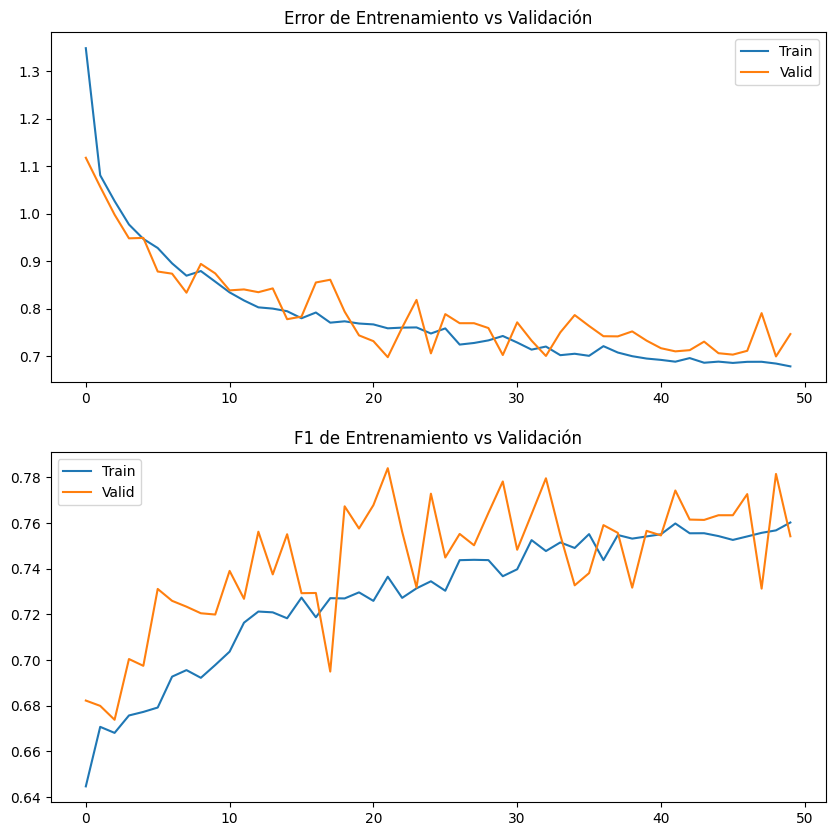

In [34]:
# Ploteo
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_met"])
axs[1].plot(history["valid_met"])
axs[1].title.set_text('F1 de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [35]:
# Cargo los mejores parámetros (min loss)
best_model_params = torch.load('best_model_params.pth')
resnet50_model.load_state_dict(best_model_params)

<All keys matched successfully>

In [36]:
# Evaluación del accuracy y Confusion Matrix
from torchmetrics.classification import MulticlassConfusionMatrix

all_labels = []
all_preds = []

# Todo debe correr en el mismo sitio
device = 'cuda'

# Aseguro el modelo en evaluation
resnet50_model.to(device)
resnet50_model.eval()  

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

confmat = MulticlassConfusionMatrix(num_classes=num_classes)
confmat(torch.tensor(all_preds), 
        torch.tensor(all_labels))


tensor([[  5,   4,   2,   0,   0,  14,   0],
        [  3,  33,   1,   0,   0,  22,   0],
        [ 22,   3,  37,   0,  14,  26,   0],
        [  0,   0,   0,   0,  13,   4,   0],
        [  6,   0,   4,   0,  36,  70,   0],
        [  1,  11,   4,   0,   9, 638,   0],
        [  0,   0,   0,   0,   0,  18,   2]])

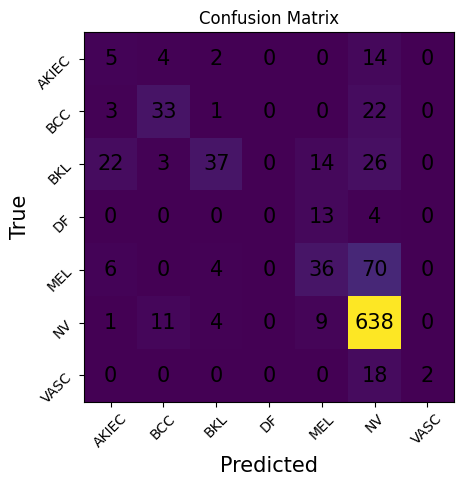

In [37]:
# Ploteo la matriz de confusion
ax_ = clases
fig_, ax_ = confmat.plot()

plt.xlabel("Predicted")
plt.ylabel("True")

ax_.set_xticklabels(clases)
plt.xticks(rotation=45)
ax_.set_yticklabels(clases)
plt.yticks(rotation=45)

plt.title("Confusion Matrix")
plt.show()

In [38]:
# Evaluación del accuracy
resnet50_model.eval()  

correctas = 0
total = 0
device = 'cuda'

with torch.no_grad():
    for imagenes, etiquetas in test_loader:
        imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
        salidas = resnet50_model(imagenes)
        _, predicciones = torch.max(salidas.data, 1)
        total += etiquetas.size(0)
        correctas += (predicciones == etiquetas).sum().item()

# Calcular el accuracy
accuracy = correctas / total
print(f'Accuracy en el conjunto de pruebas: {accuracy * 100:.2f}%')

Accuracy en el conjunto de pruebas: 74.95%


In [39]:
# Accuracy de cada clase
resnet50_model.eval()  # Asegurarte de que el modelo esté en modo de evaluación
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50_model.to(device)

correct_predictions_per_class = {i: 0 for i in range(num_classes)}
total_samples_per_class = {i: 0 for i in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet50_model(inputs)
        _, predicted_classes = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            prediction = predicted_classes[i].item()
            total_samples_per_class[label] += 1
            correct_predictions_per_class[label] += int(label == prediction)

class_accuracies = {}
for class_label, correct_predictions in correct_predictions_per_class.items():
    total_samples = total_samples_per_class[class_label]
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    class_accuracies[class_label] = accuracy

for class_label, accuracy in class_accuracies.items():
    print(f'Accuracy for Class {clases[class_label]}: {accuracy:.2%}')

Accuracy for Class AKIEC: 9.09%
Accuracy for Class BCC: 65.57%
Accuracy for Class BKL: 32.32%
Accuracy for Class DF: 0.00%
Accuracy for Class MEL: 26.09%
Accuracy for Class NV: 98.19%
Accuracy for Class VASC: 3.70%


In [40]:
# Salvo el modelo y el estado del optimizador
ruta_modelo_completo = '/kaggle/working/resnet50'
torch.save({
    'modelo_estado_dict': resnet50_model.state_dict(),
    'optimizador_estado_dict': optimizer.state_dict(),
}, ruta_modelo_completo)

Este modelo tampoco performa bien, el desbalance de los datos se refleja en las métricas.

##### *3.1.1.3. VISION TRANSFORMER*

Probemos ajustar la red Vision Transformer.

Los detalles de la red se pueden encontrar en: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

In [41]:
from torchvision.models import vit_b_16
# Ruta al archivo del modelo preentrenado en Kaggle
modelo_ruta = "/kaggle/input/modelos-tf/vit_b_16-c867db91.pth"

# Cargar el modelo desde el archivo
vitb16_model = models.vit_b_16(weights=None).to(device)
state_dict = torch.load(modelo_ruta)
vitb16_model.load_state_dict(state_dict)

<All keys matched successfully>

In [42]:
import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Utilizo la versión v2 de torchvision.transform
transform_train = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(0.5),
    v2.ColorJitter(saturation=0.1, hue=0.1),
    v2.RandomRotation(45),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]),
])

# Transformaciones de test
transform_test = v2.Compose([
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]),
])

# Cargo datasets
train_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/train', 
    transform=transform_train
)
test_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/test', 
    transform=transform_test
)

# Cargo DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=False,
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    sampler=test_sampler,
    shuffle=False, 
    num_workers=4
)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [43]:
# Congelo todas las capas de la red
for param in vitb16_model.parameters():
    param.requires_grad = False

In [44]:
# Observemos las versión corta de la arquitectura
for name, layer in vitb16_model.named_children():
    print(name, layer)

conv_proj Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
encoder Encoder(
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (encoder_layer_0): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (encoder_layer_1): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuan

In [45]:
# Se modifica la última capa
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(train_dataset.classes)
vitb16_model.heads = nn.Linear(in_features=768, out_features=num_classes).to(device)

In [46]:
# Alto y ancho de imágenes
H = 224
W = 224

In [47]:
# Corremos el entrenamiento
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

optimizer = torch.optim.Adam(vitb16_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.F1Score(task='multiclass', num_classes=num_classes)
data = {"train": train_loader, 
        "valid": test_loader, 
        "image_width": W, 
        "image_height": H}
epochs = 50
writer = {"train": SummaryWriter(log_dir="transfer_learning_ViT/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_ViT/valid")}

history = train(vitb16_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                epochs,
                writer)

/opt/conda/lib/python3.10/site-packages/torch/__init__.py:1209: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


Epoch: 1/50 - Train loss 1.201163 - Train metric 0.641923 - Valid Loss 1.010190 - Valid metric 0.658761
Epoch: 2/50 - Train loss 0.987902 - Train metric 0.676582 - Valid Loss 0.933890 - Valid metric 0.673038
Epoch: 3/50 - Train loss 0.915243 - Train metric 0.680816 - Valid Loss 0.869660 - Valid metric 0.708752
Epoch: 4/50 - Train loss 0.870676 - Train metric 0.690124 - Valid Loss 0.815213 - Valid metric 0.737119
Epoch: 5/50 - Train loss 0.834135 - Train metric 0.702577 - Valid Loss 0.754562 - Valid metric 0.760603
Epoch: 6/50 - Train loss 0.826772 - Train metric 0.702868 - Valid Loss 0.756937 - Valid metric 0.735166
Epoch: 7/50 - Train loss 0.790871 - Train metric 0.714878 - Valid Loss 0.729513 - Valid metric 0.768694
Epoch: 8/50 - Train loss 0.772123 - Train metric 0.722570 - Valid Loss 0.748785 - Valid metric 0.743908
Epoch: 9/50 - Train loss 0.744863 - Train metric 0.732792 - Valid Loss 0.733875 - Valid metric 0.747163
Epoch: 10/50 - Train loss 0.733775 - Train metric 0.738065 - Val

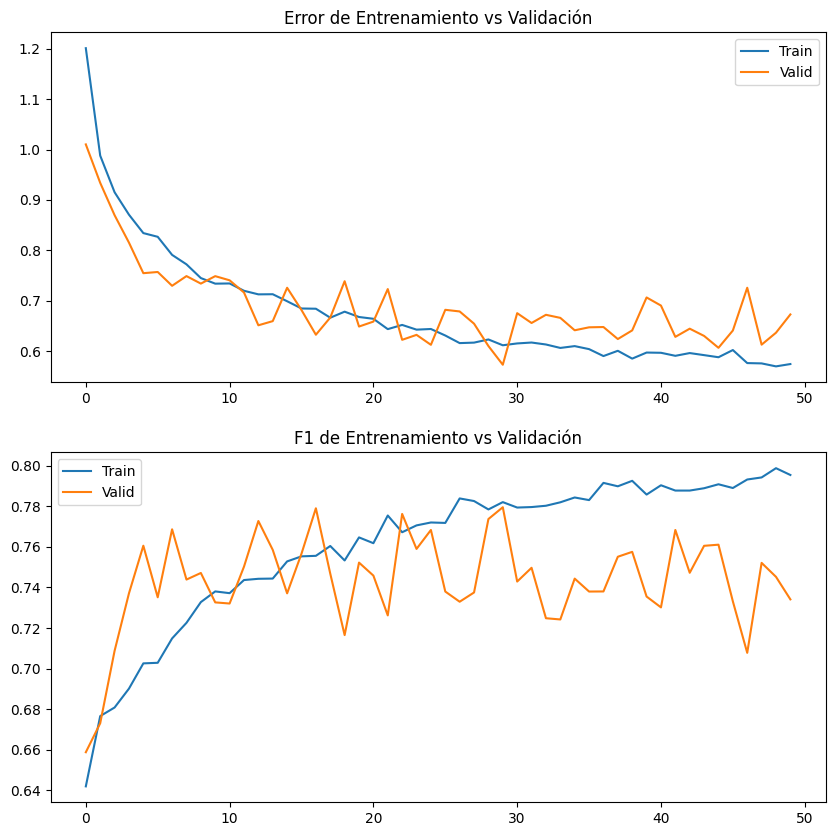

In [48]:
# Ploteo
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_met"])
axs[1].plot(history["valid_met"])
axs[1].title.set_text('F1 de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [49]:
# Cargo los mejores parámetros (min loss)
best_model_params = torch.load('best_model_params.pth')
vitb16_model.load_state_dict(best_model_params)

<All keys matched successfully>

In [50]:
# Evaluación del accuracy y Confusion Matrix
from torchmetrics.classification import MulticlassConfusionMatrix

all_labels = []
all_preds = []

# Todo debe correr en el mismo sitio
device = 'cuda'

# Aseguro el modelo en evaluation
vitb16_model.to(device)
vitb16_model.eval()  

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vitb16_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

confmat = MulticlassConfusionMatrix(num_classes=num_classes)
confmat(torch.tensor(all_preds), 
        torch.tensor(all_labels))


tensor([[ 15,   2,  11,   0,   2,   2,   0],
        [  2,  31,   0,   0,   3,  16,   1],
        [ 16,  10,  39,   0,  12,  34,   0],
        [  0,   0,  11,   0,   0,   3,   0],
        [  5,   7,  17,   0,  21,  52,   0],
        [  0,  10,  10,   0,  11, 639,   1],
        [  0,   0,   0,   0,   0,  14,   5]])

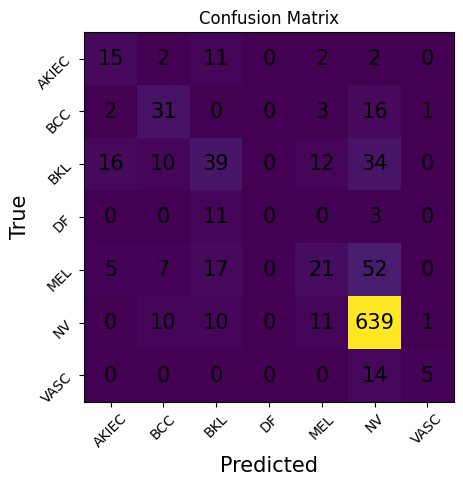

In [51]:
# Ploteo la matriz de confusion
ax_ = clases
fig_, ax_ = confmat.plot()

plt.xlabel("Predicted")
plt.ylabel("True")

ax_.set_xticklabels(clases)
plt.xticks(rotation=45)
ax_.set_yticklabels(clases)
plt.yticks(rotation=45)

plt.title("Confusion Matrix")
plt.show()

In [52]:
# Evaluación del accuracy
vitb16_model.eval()  

correctas = 0
total = 0
device = 'cuda'

with torch.no_grad():
    for imagenes, etiquetas in test_loader:
        imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
        salidas = vitb16_model(imagenes)
        _, predicciones = torch.max(salidas.data, 1)
        total += etiquetas.size(0)
        correctas += (predicciones == etiquetas).sum().item()

# Calcular el accuracy
accuracy = correctas / total
print(f'Accuracy en el conjunto de pruebas: {accuracy * 100:.2f}%')

Accuracy en el conjunto de pruebas: 77.25%


In [53]:
vitb16_model.eval()  # Asegurarte de que el modelo esté en modo de evaluación
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vitb16_model.to(device)

correct_predictions_per_class = {i: 0 for i in range(num_classes)}
total_samples_per_class = {i: 0 for i in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vitb16_model(inputs)
        _, predicted_classes = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            prediction = predicted_classes[i].item()
            total_samples_per_class[label] += 1
            correct_predictions_per_class[label] += int(label == prediction)

class_accuracies = {}
for class_label, correct_predictions in correct_predictions_per_class.items():
    total_samples = total_samples_per_class[class_label]
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    class_accuracies[class_label] = accuracy

for class_label, accuracy in class_accuracies.items():
    print(f'Accuracy for Class {clases[class_label]}: {accuracy:.2%}')

Accuracy for Class AKIEC: 29.41%
Accuracy for Class BCC: 60.61%
Accuracy for Class BKL: 28.57%
Accuracy for Class DF: 0.00%
Accuracy for Class MEL: 30.85%
Accuracy for Class NV: 94.63%
Accuracy for Class VASC: 23.53%


In [54]:
# Salvo el modelo y el estado del optimizador
ruta_modelo_completo = '/kaggle/working/ViTb16'
torch.save({
    'modelo_estado_dict': vitb16_model.state_dict(),
    'optimizador_estado_dict': optimizer.state_dict(),
}, ruta_modelo_completo)

##### **3.1.2. RED CONVOLUCIONAL SIMPLE**

Se propone entrenar desde cero una arquitectura convolucional sencilla para evaluar el desempeño. La idea es que no sea lo suficientemente profunda como para requerir conexiones residuales o que tenga excesivos requisitos de hardware/tiempo el entrenamiento.

In [55]:
CANTIDAD_CLASES = len(clases)
ANCHO_IMAGENES = 256
ALTO_IMAGENES = 256

In [56]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=32768, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

In [57]:
import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Utilizo la versión v2 de torchvision.transform
transform_train = v2.Compose([
    v2.RandomResizedCrop(256),
    v2.RandomHorizontalFlip(0.5),
    v2.ColorJitter(saturation=0.1, hue=0.1),
    v2.RandomRotation(45),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]),
])

# Transformaciones de test
transform_test = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(256),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                 std=[0.229, 0.224, 0.225]),
])

# Cargo datasets
train_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/train', 
    transform=transform_train
)
test_dataset = torchvision.datasets.ImageFolder(
    root='/kaggle/working/datasets/test', 
    transform=transform_test
)

# Cargo DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=False,
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    sampler=test_sampler,
    shuffle=False, 
    num_workers=4
)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [58]:
# Corremos el entrenamiento
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.F1Score(task='multiclass', num_classes=num_classes)
data = {"train": train_loader, 
        "valid": test_loader, 
        "image_width": 256, 
        "image_height": 256}
epochs = 50
writer = {"train": SummaryWriter(log_dir="transfer_learning_conv/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_conv/valid")}

history = train(conv_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                epochs,
                writer)

Epoch: 1/50 - Train loss 1.096617 - Train metric 0.665657 - Valid Loss 0.859694 - Valid metric 0.699963
Epoch: 2/50 - Train loss 0.936308 - Train metric 0.675940 - Valid Loss 0.816720 - Valid metric 0.708240
Epoch: 3/50 - Train loss 0.898002 - Train metric 0.685336 - Valid Loss 0.840783 - Valid metric 0.699358
Epoch: 4/50 - Train loss 0.907081 - Train metric 0.679348 - Valid Loss 0.739499 - Valid metric 0.730236
Epoch: 5/50 - Train loss 0.873297 - Train metric 0.687308 - Valid Loss 0.795216 - Valid metric 0.694475
Epoch: 6/50 - Train loss 0.874071 - Train metric 0.687797 - Valid Loss 0.777946 - Valid metric 0.709217
Epoch: 7/50 - Train loss 0.869016 - Train metric 0.687751 - Valid Loss 0.811696 - Valid metric 0.697359
Epoch: 8/50 - Train loss 0.854163 - Train metric 0.687732 - Valid Loss 0.798934 - Valid metric 0.717494
Epoch: 9/50 - Train loss 0.849419 - Train metric 0.687889 - Valid Loss 0.775636 - Valid metric 0.710100
Epoch: 10/50 - Train loss 0.836425 - Train metric 0.696303 - Val

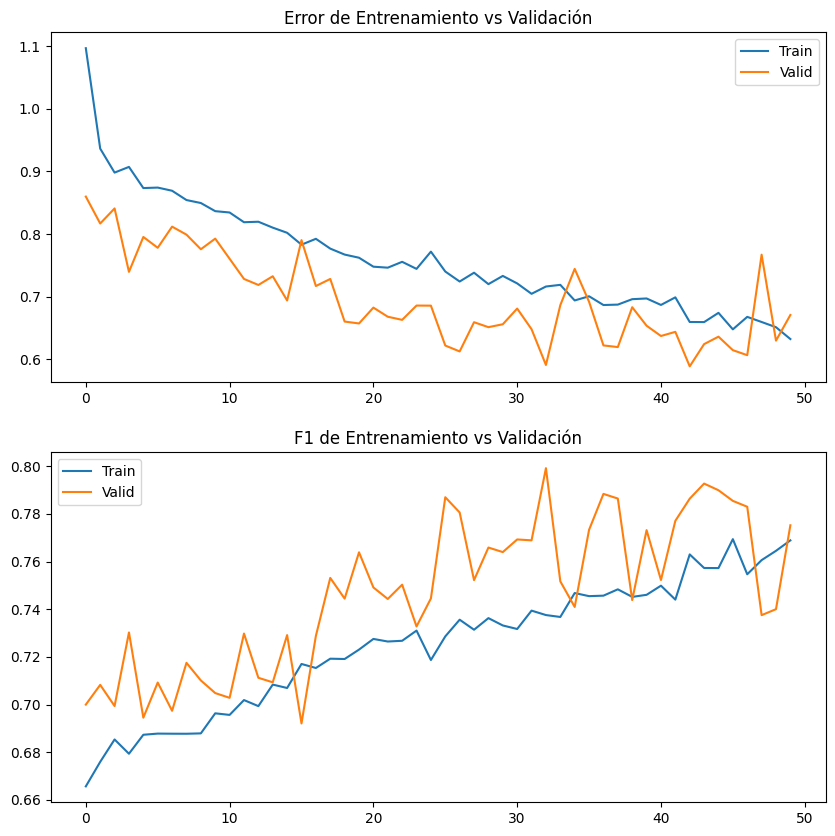

In [59]:
# Ploteo
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_met"])
axs[1].plot(history["valid_met"])
axs[1].title.set_text('F1 de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [60]:
# Cargo los mejores parámetros (min loss)
best_model_params = torch.load('best_model_params.pth')
conv_model.load_state_dict(best_model_params)

<All keys matched successfully>

In [61]:
# Evaluación del accuracy y Confusion Matrix
from torchmetrics.classification import MulticlassConfusionMatrix

all_labels = []
all_preds = []

# Todo debe correr en el mismo sitio
device = 'cuda'

# Aseguro el modelo en evaluation
conv_model.to(device)
conv_model.eval()  

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = conv_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

confmat = MulticlassConfusionMatrix(num_classes=num_classes)
confmat(torch.tensor(all_preds), 
        torch.tensor(all_labels))


tensor([[ 10,  11,   0,   0,   5,   4,   0],
        [  3,  35,  10,   0,   0,  19,   0],
        [ 12,   7,  44,   0,  10,  21,   0],
        [ 14,   1,   0,   0,   0,   4,   0],
        [  0,   0,  14,   0,  23,  42,   0],
        [  3,  10,   2,   0,  17, 661,   0],
        [  0,   0,   0,   0,   0,   3,  17]])

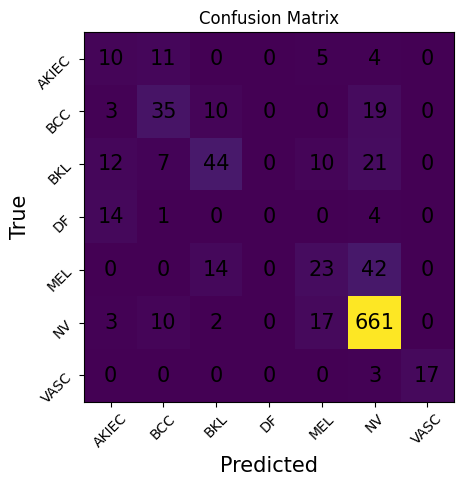

In [62]:
# Ploteo la matriz de confusion
ax_ = clases
fig_, ax_ = confmat.plot()

plt.xlabel("Predicted")
plt.ylabel("True")

ax_.set_xticklabels(clases)
plt.xticks(rotation=45)
ax_.set_yticklabels(clases)
plt.yticks(rotation=45)

plt.title("Confusion Matrix")
plt.show()

In [63]:
# Evaluación del accuracy
conv_model.eval()  

correctas = 0
total = 0
device = 'cuda'

with torch.no_grad():
    for imagenes, etiquetas in test_loader:
        imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
        salidas = conv_model(imagenes)
        _, predicciones = torch.max(salidas.data, 1)
        total += etiquetas.size(0)
        correctas += (predicciones == etiquetas).sum().item()

# Calcular el accuracy
accuracy = correctas / total
print(f'Accuracy en el conjunto de pruebas: {accuracy * 100:.2f}%')

Accuracy en el conjunto de pruebas: 79.34%


In [64]:
conv_model.eval()  # Asegurarte de que el modelo esté en modo de evaluación
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conv_model.to(device)

correct_predictions_per_class = {i: 0 for i in range(num_classes)}
total_samples_per_class = {i: 0 for i in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = conv_model(inputs)
        _, predicted_classes = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            prediction = predicted_classes[i].item()
            total_samples_per_class[label] += 1
            correct_predictions_per_class[label] += int(label == prediction)

class_accuracies = {}
for class_label, correct_predictions in correct_predictions_per_class.items():
    total_samples = total_samples_per_class[class_label]
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    class_accuracies[class_label] = accuracy

for class_label, accuracy in class_accuracies.items():
    print(f'Accuracy for Class {clases[class_label]}: {accuracy:.2%}')

Accuracy for Class AKIEC: 45.45%
Accuracy for Class BCC: 64.52%
Accuracy for Class BKL: 52.27%
Accuracy for Class DF: 0.00%
Accuracy for Class MEL: 27.85%
Accuracy for Class NV: 94.75%
Accuracy for Class VASC: 85.71%


In [65]:
# Salvo el modelo y el estado del optimizador
ruta_modelo_completo = '/kaggle/working/conv'
torch.save({
    'modelo_estado_dict': conv_model.state_dict(),
    'optimizador_estado_dict': optimizer.state_dict(),
}, ruta_modelo_completo)

***- CONTINÚA EN PARTE 2 DE 2 -***